# Logistic Regression

## 1. Import Libraries and Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# set random seed
np.random.seed(42)

## 2. Load Dataset and Prepare Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class distribution.

In [12]:
data = pd.read_csv('churn_data_cleaned.csv')

# Separate features and target
X = data.drop(columns=['TARGET'])
y = data['TARGET']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

## 3. Feature Scaling and Apply SMOTE

Scale features using StandardScaler and apply SMOTE to handle class imbalance.

In [13]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {X_train_scaled.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")

Before SMOTE: 284152 samples
After SMOTE: 522024 samples


## 4. Define Hyperparameter Grid

Set up the parameter combinations to test using GridSearchCV. We'll optimize for precision to minimize false positives.

In [14]:
print("Setting up hyperparameter grid for Logistic Regression")

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print(f"\nTotal combinations to test: {len(param_grid['C']) * len(param_grid['penalty'])}")

Setting up hyperparameter grid for Logistic Regression

Total combinations to test: 12


## 5. Perform 5-Fold Cross-Validation

Train the Logistic Regression model using 5-fold cross-validation with grid search to find the best hyperparameters.

In [15]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create base Logistic Regression model
logreg_base = LogisticRegression(random_state=42, max_iter=1000)

# Set up GridSearchCV with Precision as the metric
grid_search = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Perform grid search on SMOTE-resampled training data
grid_search.fit(X_train_smote, y_train_smote)

print("Grid search complete.")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   1.6s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   1.6s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   1.6s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   1.7s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   2.0s
[CV] END ...............C=0.01, penalty=l1, solv

## 6. Display Cross-Validation Results

Show the best parameters found and the top 5 parameter combinations based on precision score.

In [16]:
# Display best parameters and cross-validation results
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

# Display top 5 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score']
]

print("\nTop 5 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"  Parameters: {row['params']}")
    print(f"  CV Precision Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Precision Score: {row['mean_train_score']:.4f}")
    print("\n")


Best Parameters Found:
  C: 1
  penalty: l2
  solver: liblinear

Best Cross-Validation Precision Score: 0.6474

Top 5 Parameter Combinations:
  Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
  CV Precision Score: 0.6474 (+/- 0.0010)
  Train Precision Score: 0.6475


  Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
  CV Precision Score: 0.6474 (+/- 0.0010)
  Train Precision Score: 0.6475


  Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
  CV Precision Score: 0.6474 (+/- 0.0010)
  Train Precision Score: 0.6475


  Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  CV Precision Score: 0.6474 (+/- 0.0010)
  Train Precision Score: 0.6475


  Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
  CV Precision Score: 0.6474 (+/- 0.0010)
  Train Precision Score: 0.6475




## 7. Evaluate Model Performance

Use the best model from grid search and calculate performance metrics on the test set.

In [17]:
# Train final Logistic Regression model with best parameters from cross-validation
logreg_final = grid_search.best_estimator_

print(f"\nFinal Logistic Regression Model:")
print(f"  C: {logreg_final.C}")
print(f"  penalty: {logreg_final.penalty}")
print(f"  solver: {logreg_final.solver}")

# Predict and evaluate on test set
y_pred = logreg_final.predict(X_test_scaled)
y_proba = logreg_final.predict_proba(X_test_scaled)[:, 1]

target_names = ['No Churn', 'Churn']

# Evaluate performance
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_roc:.4f}")


Final Logistic Regression Model:
  C: 1
  penalty: l2
  solver: liblinear

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.60      0.74     65253
       Churn       0.14      0.71      0.23      5785

    accuracy                           0.61     71038
   macro avg       0.55      0.65      0.48     71038
weighted avg       0.89      0.61      0.69     71038

Performance Metrics
Precision:  0.1352
Recall:     0.7113
F1 Score:   0.2272
AUC-ROC:    0.7104


## 8. Visualize Results

Plot confusion matrix and ROC curve to visualize model performance.

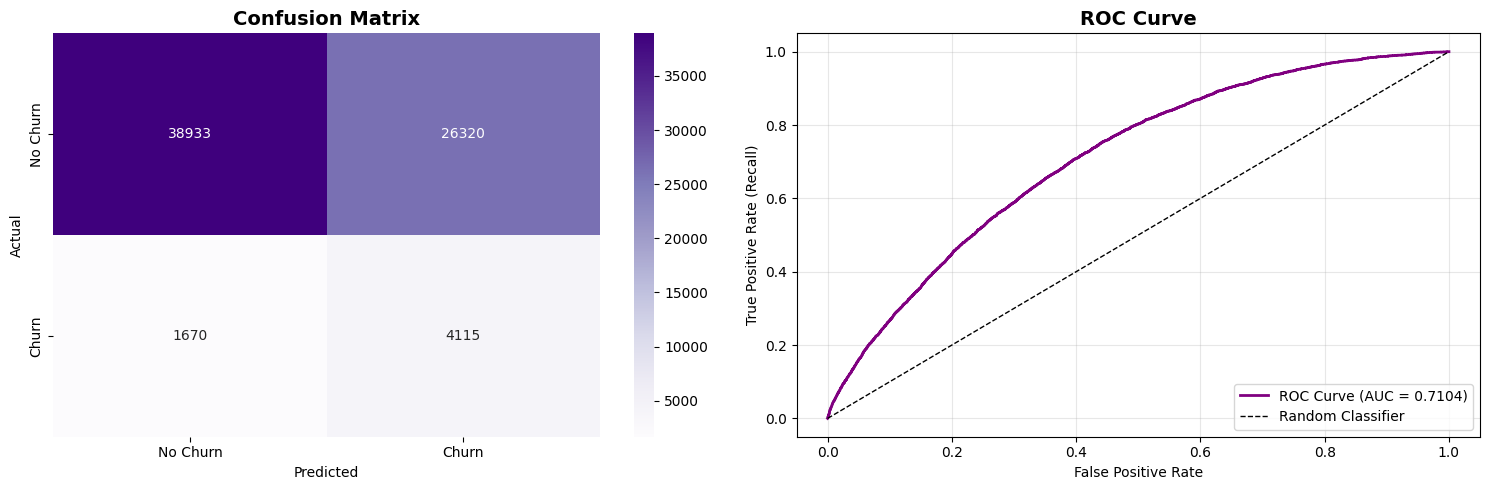

In [18]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})', color='purple')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()